<a href="https://colab.research.google.com/github/Rohan6672/Alien-Invader/blob/master/Week_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/LFW_Week5')


Mounted at /content/drive


In [2]:
import requests
import tarfile
import os
import numpy as np
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
from typing import List
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras, TensorSpec, dtypes
from tensorflow.data import Dataset, AUTOTUNE

import bz2
from face_recognition.align import AlignDlib


In [3]:
data_dir_name = 'data'
lfw_data_path = os.path.join(data_dir_name, 'lfw')

landmarks_dir = 'models'
landmarks_path = os.path.join(landmarks_dir, 'landmarks.dat')

training_pairs_name = 'pairsDevTrain.txt'
testing_pairs_name = 'pairsDevTest.txt'


In [4]:
class LfwDataGenerator():
    # Initialization Function
    def __init__(self, pairs_file_name, batch_size=4, anchor_shape=(96,96), n_channels=3, 
        img_aug=False, face_align=False,landmarks_path=landmarks_path, data_path=lfw_data_path):
        self.pairs_file_name = pairs_file_name
        self.batch_size = batch_size
        self.anchor_shape = anchor_shape
        self.n_channels = n_channels
        self.img_aug = img_aug
        self.face_align = face_align
        # read the pairs_file_name and stores the image paths as lists of tuples of 
        # either positive or negative pairs
        self.positive_pairs = []
        self.negative_pairs = []
        with open(pairs_file_name, 'rt') as f:
            for line in f:
                tokens = line.split()
                if len(tokens) == 3:
                       self.positive_pairs.append([(tokens[0],tokens[1]),(tokens[0],tokens[2])])
                elif len(tokens) == 4:
                    self.negative_pairs.append([(tokens[0],tokens[1]),(tokens[2],tokens[3])])
        
        min_len = min(len(self.positive_pairs), len(self.negative_pairs))
        self.pos_indexes = np.arange(min_len)
        self.neg_indexes = np.arange(min_len)
        self.alignment = AlignDlib(landmarks_path) # create the face alignment model
        self.augmenter = iaa.Sequential([ # create the image augmenter
            iaa.Crop(px=(0,16)), # crop images from each side by 0 to 16px (randomly chosen)
            iaa.Fliplr(0.5), # horizontally flip 50% of the images
            iaa.GaussianBlur(sigma=(0,1.0)), # blur images with a sigma of 0 to 3.0
            iaa.GammaContrast((0.5, 2.0)), # adjust the image contrast 
        ])
    # Length Function
    def __len__(self):
        return len(self.pos_indexes)
    # Get Image Path Function
    def get_image_path(self, name, id):
        path_name = os.path.join(lfw_data_path, name)
        return os.path.join(path_name, name) + "_" + f"{id}".zfill(4) + ".jpg"
    # Load Image Function
    def load_image(self, name, id):
        img = cv2.imread(self.get_image_path(name, id))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype('float32')
        img = img / 255.0
        return img
    # Get Item Function
    def __getitem__(self, index):
        pos_pair = self.positive_pairs[self.pos_indexes[index]]
        neg_pair = self.negative_pairs[self.neg_indexes[index]]
    
        pos_name, pos_id_1 = pos_pair[0]
        anchor_img = self.load_image(pos_name, pos_id_1)
        
        pos_name, pos_id_2 = pos_pair[1]
        pos_img = self.load_image(pos_name, pos_id_2)
        
        neg_name, neg_id = neg_pair[0]
        if pos_name == neg_name:
            neg_name, neg_id = neg_pair[1]
        neg_img = self.load_image(neg_name, neg_id)
        if self.face_align:
            anchor_img = self.align_image(anchor_img)
            pos_img = self.align_image(pos_img)
            neg_img = self.align_image(neg_img)
        if self.img_aug:
            anchor_img = self.augment_image(anchor_img)
            pos_img = self.augment_image(pos_img)
            neg_img = self.augment_image(neg_img)
        # Resize Images
        anchor_img = cv2.resize(anchor_img, self.anchor_shape)
        pos_img = cv2.resize(pos_img, self.anchor_shape)
        neg_img = cv2.resize(neg_img, self.anchor_shape)
        return (anchor_img, pos_img, neg_img), None
    # Generate Function
    def generate(self):
        for index in self.pos_indexes:
            yield self[index]
    # Get Generator Function
    def get_generator(self):
        tfdatagen = Dataset.from_generator(
            # create a tf.Dataset generator using the generate method
            self.generate, 
            # define the outputs of the tf.Dataset generator
            output_signature=(
                # Input: image shapes and datatypes
                (TensorSpec((self.anchor_shape[0], self.anchor_shape[1], self.n_channels), 
                            dtypes.float32),
                TensorSpec((self.anchor_shape[0], self.anchor_shape[1], self.n_channels), 
                            dtypes.float32),
                TensorSpec((self.anchor_shape[0], self.anchor_shape[1], self.n_channels), 
                            dtypes.float32)),
                # Label Embeddings
                TensorSpec(None)))
        return (tfdatagen
            # set the batch size
            .batch(self.batch_size)
            # shuffle to randomly select images
            .shuffle(self.batch_size*2)
            # prefetch for performance optimization
            .prefetch(AUTOTUNE))
    # Image Augmentation Function
    def augment_image(self, img):
        return self.augmenter(images=[img])[0]
    # Image Align Function
    def align_image(self, img):
        img = (img*255).astype("uint8")
        alignment = self.alignment
        bb = alignment.getLargestFaceBoundingBox(img) # get face bounding box
        if bb is not None:
            img = alignment.align(self.anchor_shape[0],img,bb,
                                    landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
        return img.astype("float32") / 255










In [5]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
class TripletLossLayer(Layer):
    # Function: Initialize
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    # Function: Get Configuration
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'alpha' : self.alpha,
        })
        return config
    # Function: Triplet Loss
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a - p), axis = -1)
        n_dist = K.sum(K.square(a - n), axis = -1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis = 0)
    # Function: Call
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    # Function:













In [6]:


      
# Initialize the data generator
class OldLfwDataGenerator():
  

  def __init__(self, pairs_file_name, batch_size=4, anchor_shape=(96,96), n_channels=3, 
img_aug=False, face_align=False, data_path=lfw_data_path):
        self.pairs_file_name = pairs_file_name
        self.batch_size = batch_size
        self.anchor_shape = anchor_shape
        self.n_channels = n_channels
        self.img_aug = img_aug
        self.face_align = face_align
        self.positive_pairs = []
        self.negative_pairs = []
        with open(pairs_file_name, 'rt') as f:
            for line in f:
                tokens = line.split()
                if len(tokens) == 3:
              	     self.positive_pairs.append([(tokens[0],tokens[1]),(tokens[0],tokens[2])])
                elif len(tokens) == 4:
                    self.negative_pairs.append([(tokens[0],tokens[1]),(tokens[2],tokens[3])])
        
        min_len = min(len(self.positive_pairs), len(self.negative_pairs))
        self.pos_indexes = np.arange(min_len)
        self.neg_indexes = np.arange(min_len)

  def __len__(self):
      return len(self.pos_indexes)

  # helper functions to load images
  def get_image_path(self, name, id):
      path_name = os.path.join(lfw_data_path, name)
      return os.path.join(path_name, name) + "_" + f"{id}".zfill(4) + ".jpg"

  def load_image(self, name, id):
      img = cv2.imread(self.get_image_path(name, id))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = img.astype('float32')
      img = img / 255.0
      return img
  def __getitem__(self, index):
      pos_pair = self.positive_pairs[self.pos_indexes[index]]
      neg_pair = self.negative_pairs[self.neg_indexes[index]]
      
      pos_name, pos_id_1 = pos_pair[0]
      anchor_img = self.load_image(pos_name, pos_id_1)
      
      pos_name, pos_id_2 = pos_pair[1]
      pos_img = self.load_image(pos_name, pos_id_2)
      
      neg_name, neg_id = neg_pair[0]
      if pos_name == neg_name:
          neg_name, neg_id = neg_pair[1]
      neg_img = self.load_image(neg_name, neg_id)
          
      return (anchor_img,pos_img,neg_img),None
  def generate(self):
      for index in self.pos_indexes:
          yield self[index]
  def get_generator(self):
      tfdatagen = Dataset.from_generator(
          self.generate, 
          output_signature=(
            (TensorSpec((self.anchor_shape[0],self.anchor_shape[1],self.n_channels),
                        dtypes.float32),
             TensorSpec((self.anchor_shape[0],self.anchor_shape[1],self.n_channels),
                        dtypes.float32),
             TensorSpec((self.anchor_shape[0],self.anchor_shape[1],self.n_channels),
                        dtypes.float32)),TensorSpec(None))
      )
      return (tfdatagen
          # set the batch size
          .batch(self.batch_size)
          # shuffle to randomly select images
          .shuffle(self.batch_size*2)
          # prefetch for performance optimization
          .prefetch(AUTOTUNE)
          )






batchsize = 4 # Number of tuples in each batch
generator = LfwDataGenerator(pairs_file_name = training_pairs_name, 
                             batch_size=batchsize, 
                             img_aug = True, 
                             face_align=True)


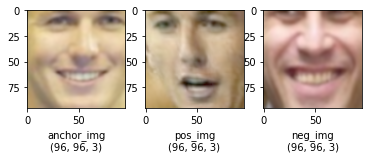

In [7]:
# Retrieve tuple of images
(anchor_img, pos_img, neg_img), embedding = generator[1]

# Show anchor, positive, negative images and their shapes
plt.subplot(1, 3, 1)
plt.imshow(anchor_img)
plt.xlabel("anchor_img\n" + str(anchor_img.shape))

plt.subplot(1, 3, 2)
plt.imshow(pos_img)
plt.xlabel("pos_img\n" + str(pos_img.shape))

plt.subplot(1, 3, 3)
plt.imshow(neg_img)
plt.xlabel("neg_img\n" + str(neg_img.shape))

plt.show()


In [8]:
import matplotlib.patches as patches

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [9]:
# Input for anchor, positive, and negative images
in_a = Input(shape=(96, 96, 3), name="img_a")
in_p = Input(shape=(96, 96, 3), name="img_p")
in_n = Input(shape=(96, 96, 3), name="img_n")
...

# create the base model from EfficientNetB0
base_cnn = EfficientNetB0(input_shape=(96, 96, 3), include_top=False)

flatten = layers.Flatten()(base_cnn.output)
dense = layers.Dense(512, activation="relu")(flatten)
dense = layers.BatchNormalization()(dense)
output = layers.Dense(128)(dense)

embedding = Model(base_cnn.input, output, name="Embedding")

...

# Output the embedding vectors from anchor, positive, and negative images
# The model weights are shared (Triplet network)
emb_a = embedding(in_a)
emb_p = embedding(in_p)
emb_n = embedding(in_n)

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])






16719872/16705208 [==============================] - 0s 0us/step


In [10]:
model=Model([in_a,in_p,in_n],triplet_loss_layer)
model.compile(loss=None,optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_a (InputLayer)             [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 img_p (InputLayer)             [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 img_n (InputLayer)             [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Embedding (Functional)         (None, 128)          10016035    ['img_a[0][0]',                  
                                                                  'img_p[0][0]',              

In [11]:
%pwd

'/content/drive/MyDrive/LFW_Week5'

In [12]:
EPOCHS = 10 # Maximum number of epochs

# Train model on dataset
# ModelCheckpoint will automatically save the best model
# EarlyStopping will automatically stop when it stops improving
model.fit(generator.get_generator(), 
    epochs = EPOCHS, 
    callbacks=[ModelCheckpoint(filepath='ckpts/epoch{epoch:03d}_loss{loss:.3f}.hdf5',
                                monitor = 'loss',
                                save_best_only = True,
                                mode = 'auto',
                                save_weights_only = True,
                                verbose = 1),
                EarlyStopping(monitor='loss',
                              mode='auto',
                              patience=3,
                              verbose=True)])


Epoch 1/10
     29/Unknown - 169s 4s/step - loss: 190.0692

UnknownError: ignored

In [ ]:
base_model = model.get_layer("Embedding")

In [ ]:
def embedding_distance(embedding1, embedding2):
  # Return L2 distance
  return np.sum(np.square(embedding1 - embedding2))



In [ ]:
alignment = AlignDlib(landmarks_path) # create the face alignment model
augmenter = iaa.Sequential([ # create the image augmenter
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0,1.0)), # blur images with a sigma of 0 to 3.0
    iaa.GammaContrast((0.5, 2.0)), # adjust the image contrast
])

def preprocess_image(img_path="", img_aug=True, face_align=True, alignment=alignment, augmenter=augmenter, target_shape=(96,96)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if face_align and (alignment is not None):
        bb = alignment.getLargestFaceBoundingBox(img) # get face bounding box
        if bb is not None:
            img = alignment.align(target_shape[0], img, bb,
                                  landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    img = img.astype("float32") / 255.0
    if img_aug and (augmenter is not None):
        img = augmenter(images=[img])[0]
    img = cv2.resize(img, target_shape)
    img = np.expand_dims(img,axis = 0)
    return img



In [ ]:
# Build dataset of COML images
COML_images = []
face_data_dir = '/content/drive/Shareddrives/2022 FIRE COML STUDENTS/Spring/Face Photos Dataset'
persons = os.listdir(face_data_dir)
img_exts = ('.png','.jpg','.jpeg')
# List of (person_name, image_filepath)
for i, person in enumerate(persons):
    person_path = os.path.join(face_data_dir, person)
    person_files = os.listdir(person_path)
    image_files = [(person, os.path.join(face_data_dir, person_path, image_file)) for image_file in person_files if image_file.endswith(img_exts)]
    COML_images.extend(image_files)
# Remove images that can't be loaded
COML_images = [(person, image_file) for (person, image_file) in COML_images if cv2.imread(image_file) is not None]
print(len(COML_images))    






In [ ]:
#embeddings = [(person, img, base_model.predict(preprocess_image(img))) for (person, img) in COML_images]
# Create embedding for test image
embedding_file  = '/content/Faces 10.jpeg'
my_embedding = base_model.predict(preprocess_image(embedding_file ))


# Calculate embedding distances and find shortest distances
embedding_distances = [embedding_distance(my_embedding, embedding) for (person, img, embedding) in embeddings]
shortest_distances = sorted(embedding_distances)

# Show images and distances
#plt.imshow(np.squeeze(preprocess_image(embedding_dir)))
plt.show()

for i in range(5):
    distance = shortest_distances[i]
    index = embedding_distances.index(distance)
    (person, img, _) = embeddings[index]
    plt.imshow(np.squeeze(preprocess_image(img)))
    plt.show()
    print(f'Top {i + 1} most similar person and embedding distance: {person}, {distance}')



In [ ]:
# Create embedding for test image
embedding_file  = '/content/drive/MyDrive/LFW_Week5/Unknown.jpeg'
my_embedding = base_model.predict(preprocess_image(embedding_file ))


# Calculate embedding distances and find shortest distances
embedding_distances = [embedding_distance(my_embedding, embedding) for (person, img, embedding) in embeddings]
shortest_distances = sorted(embedding_distances)

# Show images and distances
# plt.imshow(np.squeeze(preprocess_image(embedding_dir)))
plt.show()

for i in range(5):
    distance = shortest_distances[i]
    index = embedding_distances.index(distance)
    (person, img, _) = embeddings[index]
    plt.imshow(np.squeeze(preprocess_image(img)))
    plt.show()
    print(f'Top {i + 1} most similar person and embedding distance: {person}, {distance}')



In [ ]:
# Create embedding for test image
embedding_files  = ['/content/drive/MyDrive/LFW_Week5/Unknown-'+str(x)+'.jpeg' for x in range(10)]
my_embeddings = [base_model.predict(preprocess_image(f )) for f in embedding_files]


# Calculate embedding distances and find shortest distances
embedding_distances = [[embedding_distance(my_embedding, embedding) for (person, img, embedding) in embeddings] for my_embedding in my_embeddings]
shortest_distances = [sorted(ed) for ed in embedding_distances]

# Show images and distances
# plt.imshow(np.squeeze(preprocess_image(embedding_dir)))
# plt.show()

for i in range(10):
    distance = shortest_distances[0]
    index = embedding_distances[i].index(distance)
    (person, img, _) = embeddings[index]
    plt.imshow(np.squeeze(preprocess_image(img)))
    plt.show()
    print(f'Top 1 most similar person and embedding distance: {person}, {distance}')

